In [29]:
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
# import XGBoost
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

import pickle

import matplotlib.pyplot as plt

In [21]:
### SET HYPERPARAMETERS
GENES_SELECTION = 1000
CNA_SELECTION = 1000

In [2]:
patient_df = pd.read_csv("/home/rimichael/Uni/biohack/bric/data_clinical_patient.txt", sep="\t", skiprows=4)
patient_df = patient_df.set_index('PATIENT_ID')
patient_df

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,INTCLUST,AGE_AT_DIAGNOSIS,OS_MONTHS,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,RADIO_THERAPY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY
PATIENT_ID,,,,,,,,,,,,,,,,,,,,
MB-0000,10.0,6.044,NaN,NO,1.0,Positve,NEUTRAL,YES,Post,4ER+,75.65,140.500000,LIVING,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY
MB-0002,0.0,4.020,High,NO,1.0,Positve,NEUTRAL,YES,Pre,4ER+,43.19,84.633333,LIVING,LumA,ER+/HER2- High Prolif,Living,Right,YES,Ductal/NST,BREAST CONSERVING
MB-0005,1.0,4.030,High,YES,1.0,Positve,NEUTRAL,YES,Pre,3,48.87,163.700000,DECEASED,LumB,NaN,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY
MB-0006,3.0,4.050,Moderate,YES,1.0,Positve,NEUTRAL,YES,Pre,9,47.68,164.933333,LIVING,LumB,NaN,Living,Right,YES,Mixed,MASTECTOMY
MB-0008,8.0,6.080,High,YES,1.0,Positve,NEUTRAL,YES,Post,9,76.97,41.366667,DECEASED,LumB,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MTS-T2428,0.0,2.540,NaN,NaN,1.0,Positve,NaN,NaN,NaN,NaN,70.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTS-T2429,0.0,4.560,NaN,NaN,1.0,Positve,NaN,NaN,NaN,NaN,63.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTS-T2430,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
sub_patient_df = patient_df[["OS_MONTHS", "OS_STATUS", "INTCLUST","VITAL_STATUS"]]
sub_patient_df

,OS_MONTHS,OS_STATUS,INTCLUST,VITAL_STATUS
PATIENT_ID,,,,
MB-0000,140.500000,LIVING,4ER+,Living
MB-0002,84.633333,LIVING,4ER+,Living
MB-0005,163.700000,DECEASED,3,Died of Disease
MB-0006,164.933333,LIVING,9,Living
MB-0008,41.366667,DECEASED,9,Died of Disease
...,...,...,...,...
MTS-T2428,NaN,NaN,NaN,NaN
MTS-T2429,NaN,NaN,NaN,NaN
MTS-T2430,NaN,NaN,NaN,NaN


In [4]:
cna_df = pd.read_csv("/home/rimichael/Uni/biohack/bric/data_CNA.txt", sep="\t")
cna_df = cna_df.drop(columns="Entrez_Gene_Id")
cna_df = cna_df.T
cna_df.columns = cna_df.iloc[0]
cna_df = cna_df.drop("Hugo_Symbol")
cna_df

Hugo_Symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
MB-0000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MB-0039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,0,0
MB-0045,-1,-1,0,-1,-1,-1,-1,0,0,2,...,0,0,0,0,0,1,-1,0,-2,0
MB-0046,0,0,0,-1,-1,-1,-1,0,-1,0,...,0,0,-1,-1,0,0,0,0,-1,0
MB-0048,0,0,1,0,0,0,0,0,-1,0,...,0,1,0,0,0,0,0,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-6020,1,1,0,0,0,0,0,0,-1,0,...,0,0,-1,-1,0,0,0,0,-1,2
MB-6213,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MB-6230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-1,-1,0,0,0
MB-7148,0,0,-1,0,0,0,0,-1,0,0,...,0,-1,0,0,0,0,0,0,0,0


In [5]:
# combined dataset
cna_data_df = cna_df.join(sub_patient_df, how="left")
cna_train_df = cna_data_df.drop(columns=["OS_STATUS", "OS_MONTHS", "VITAL_STATUS"]).dropna()
y = cna_train_df["INTCLUST"]
y

MB-0000    4ER+
MB-0039    4ER+
MB-0045    4ER-
MB-0046       5
MB-0048    4ER+
           ... 
MB-7133       1
MB-0156    4ER+
MB-0210    4ER+
MB-0635    4ER+
MB-0876    4ER-
Name: INTCLUST, Length: 1898, dtype: object

In [6]:
cna_train_df = cna_train_df.drop(columns="INTCLUST")

In [7]:
# take expression into account
expression_df = pd.read_csv("/home/rimichael/Uni/biohack/bric/data_expression_median.txt",sep="\t")
expression_df = expression_df.set_index("Hugo_Symbol")
expression_df = expression_df.drop(columns="Entrez_Gene_Id").T
expression_df

Hugo_Symbol,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,...,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
MB-0362,8.676978,6.075331,5.453928,4.994525,5.838270,6.397503,7.906217,5.259461,5.702379,6.930741,...,5.271343,5.680321,7.688492,8.084979,5.161796,6.353215,4.836483,7.304643,5.251843,5.049591
MB-0346,9.653589,6.687887,5.454185,5.346010,5.600876,5.246319,8.267256,5.380069,5.521794,6.141689,...,5.942887,5.461069,7.804165,8.349115,5.197392,6.132355,5.316819,7.933324,5.450611,5.316790
MB-0386,9.033589,5.910885,5.501577,5.247467,6.030718,10.111816,7.959291,5.262024,5.689533,6.529312,...,5.174498,5.304030,7.934309,8.406332,8.087722,6.366335,5.466419,7.580336,5.235394,5.461617
MB-0574,8.814855,5.628740,5.471941,5.316523,5.849428,6.116868,9.206376,5.396576,5.439130,6.430102,...,5.116749,5.632249,7.744562,8.310019,5.780062,6.424048,5.193150,6.903654,5.091927,5.227130
MB-0503,9.274265,5.908698,5.531743,5.244094,5.964661,7.828171,8.706646,5.167213,5.417484,6.684893,...,5.402314,5.472185,7.701394,8.137014,5.498185,6.214301,5.274600,6.839417,5.315224,5.027476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-5465,8.131637,9.101942,5.423027,4.939292,5.644587,5.611189,7.798269,5.219962,5.597732,6.583524,...,5.417529,5.484696,7.643929,8.040024,5.456862,6.269748,5.337776,7.288315,5.359223,5.253696
MB-5453,9.606915,7.427494,5.534115,5.062191,5.927409,5.927031,8.520545,5.129501,5.550549,5.841476,...,5.566320,5.538543,7.048923,7.560101,5.397010,7.088676,5.216496,7.248336,5.544276,5.436415
MB-5471,9.049296,6.850000,5.339346,5.166765,6.117095,6.374305,8.499637,4.961279,5.497546,6.351428,...,5.484182,5.386238,7.733413,7.941895,5.415928,6.110477,5.427567,7.596215,5.405179,5.094339
MB-5127,8.858622,6.550450,5.566071,5.140141,5.936371,5.963092,9.320207,5.408996,5.690297,7.280037,...,5.403071,5.436583,7.311774,7.866579,5.242482,6.316304,4.977467,6.620605,5.631662,5.350708


In [8]:
# do recursive feature elimination for a tree fit on gene expression data
# split gene data into test and training
gene_data_df = expression_df.join(patient_df["INTCLUST"], how="left").dropna()
gene_X_df = gene_data_df.drop(columns="INTCLUST")
gene_y_df = gene_data_df["INTCLUST"]

X_gene_train, X_gene_test, y_gene_train, y_gene_test = train_test_split(gene_X_df, 
                                                                        gene_y_df, test_size=0.22, random_state=1234)

X_gene_train

,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,...,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
MB-4966,9.291692,6.411249,5.605282,5.063649,6.003271,6.735609,9.128725,5.314463,5.578489,7.171869,...,5.260648,5.234746,7.100904,7.983542,5.057194,6.365567,5.373097,7.583714,5.509426,5.554543
MB-0442,9.113783,6.015336,5.669313,5.426407,5.665439,8.460771,9.007343,5.244298,5.535573,5.595616,...,5.522175,5.598926,7.183373,7.944622,5.400700,5.634848,5.251053,6.767750,5.251676,5.230243
MB-4140,9.472043,5.910744,5.426901,5.223268,7.138441,5.779727,8.222894,5.101516,5.761124,6.318411,...,5.670318,5.454181,8.068413,8.329161,5.334215,6.494326,5.328042,6.618754,5.143839,5.646772
MB-0375,8.836655,5.852575,5.231698,5.151452,5.678047,5.416510,8.814137,5.320135,5.389053,6.179701,...,5.549034,5.628941,7.675028,8.627779,5.331394,6.436519,5.247447,7.459989,5.571634,5.295922
MB-4944,9.476825,7.109797,5.686820,5.263275,5.864668,5.413119,8.164442,5.287566,5.531523,6.285579,...,5.262310,5.374889,7.291418,8.604917,5.093681,6.486328,5.266707,7.847362,5.421091,5.348771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7046,8.391464,6.228934,5.530951,5.268691,5.861127,5.806074,8.573571,5.630381,5.891591,6.512292,...,6.318094,5.572153,7.346398,7.975453,5.308320,5.809825,5.093884,7.037958,5.306944,5.727501
MB-7220,9.246479,7.071885,5.509670,5.033000,6.413970,5.361654,8.458108,5.223185,5.680159,6.279207,...,5.221530,5.458701,7.872295,8.367442,5.149893,6.333468,5.157504,7.241848,5.347925,5.414391
MB-4881,8.437415,7.121855,5.679620,5.283746,5.622256,5.550178,7.641001,5.489841,5.625037,6.451369,...,5.616068,5.543733,7.946166,9.159409,5.267296,6.540999,5.503468,8.036148,5.421123,5.567413
MB-5486,8.998274,6.234364,5.478249,5.130203,5.817029,6.115662,8.354359,5.425631,5.727101,6.414901,...,5.402381,5.431000,7.946268,8.159615,5.250304,6.036492,5.224467,7.360788,5.367250,5.452044


In [9]:
print("CNA dim:")
print(cna_df.shape)

total_data_df = cna_df.join(patient_df["INTCLUST"], how="left")
total_data_df = total_data_df.join(expression_df, how="inner", rsuffix="_expr").dropna()

print("CNA-expression join dim:")
print(total_data_df.shape)

#X_train, X_test, y_train, y_test
y_total = total_data_df["INTCLUST"]
X_total = total_data_df.drop(columns="INTCLUST")

print("X total dim:")
print(X_total.shape)

X_total

CNA dim:
(2173, 22544)
CNA-expression join dim:
(1885, 46913)
X total dim:
(1885, 46912)


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,BX115874,BX107598,UGCGL1,VPS72_expr,CSMD3_expr,CC2D1A_expr,CB986545,IGSF9_expr,DA110839,FAM71A_expr
MB-0000,0,0,0,0,0,0,0,0,0,0,...,5.329883,5.745324,7.021679,8.010657,5.299815,6.235804,5.349555,5.947404,5.615147,5.133576
MB-0039,0,0,0,0,0,0,0,0,0,0,...,5.951742,5.928352,7.926861,7.331212,5.450666,5.985447,5.458363,5.390357,5.706905,5.498739
MB-0045,-1,-1,0,-1,-1,-1,-1,0,0,2,...,5.379279,5.761502,7.807015,8.301804,5.313254,6.281194,5.390784,6.264153,5.426428,5.547820
MB-0046,0,0,0,-1,-1,-1,-1,0,-1,0,...,5.204814,5.667425,7.715507,8.488727,5.307310,6.071653,5.264978,7.837516,5.321490,5.390555
MB-0048,0,0,1,0,0,0,0,0,-1,0,...,5.520178,5.582338,7.194426,7.496171,5.176560,6.065291,5.180065,5.651414,5.358560,5.825701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-0897,1,1,0,1,1,1,1,0,0,0,...,5.762214,5.413955,8.015040,7.625434,5.460659,6.173629,5.327471,6.012906,5.323286,5.303015
MB-0901,-1,-1,0,-1,0,0,-1,0,0,0,...,5.235796,5.765693,7.529660,8.957720,5.149128,6.778161,5.190845,7.023723,5.425389,5.164326
MB-0904,-1,-1,0,0,0,0,0,0,0,0,...,5.437678,5.468330,7.875687,8.261096,5.266329,6.164476,5.142309,6.627725,5.174867,5.655427
MB-0906,0,0,0,0,0,0,0,0,0,0,...,5.302793,5.313292,8.320815,8.072270,5.396927,6.380106,5.178450,6.297808,5.361632,4.744593


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.22, random_state=1234)

In [106]:
cna_clf = RFE(RandomForestClassifier(max_depth= 25, max_leaf_nodes= 30, 
                                       n_estimators= 300, n_jobs=6),
               CNA_SELECTION, step=100, verbose=1)

cna_clf.fit(X_cna_train, y_cna_train)


Fitting estimator with 22544 features.
Fitting estimator with 22444 features.
Fitting estimator with 22344 features.
Fitting estimator with 22244 features.
Fitting estimator with 22144 features.
Fitting estimator with 22044 features.
Fitting estimator with 21944 features.
Fitting estimator with 21844 features.
Fitting estimator with 21744 features.
Fitting estimator with 21644 features.
Fitting estimator with 21544 features.
Fitting estimator with 21444 features.
Fitting estimator with 21344 features.
Fitting estimator with 21244 features.
Fitting estimator with 21144 features.
Fitting estimator with 21044 features.
Fitting estimator with 20944 features.
Fitting estimator with 20844 features.
Fitting estimator with 20744 features.
Fitting estimator with 20644 features.
Fitting estimator with 20544 features.
Fitting estimator with 20444 features.
Fitting estimator with 20344 features.
Fitting estimator with 20244 features.
Fitting estimator with 20144 features.
Fitting estimator with 20

Fitting estimator with 1244 features.
Fitting estimator with 1144 features.
Fitting estimator with 1044 features.


RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=25, max_features='auto',
                                     max_leaf_nodes=30, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=300, n_jobs=6,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=1000, step=100, verbose=1)

In [107]:
print(cna_clf.score(X_cna_test, y_cna_test))

0.6244019138755981


In [108]:
top_cna_list = list(X_cna_train.iloc[:, cna_clf.support_])
X_cna_train.iloc[:, cna_clf.support_]

,AAMDC,AARD,AARS,AARSD1,ABCA10,ABCA17P,ABCA3,ABCA5,ABCA6,ABCA8,...,ZNF689,ZNF696,ZNF703,ZNF704,ZNF706,ZNF768,ZNF785,ZNF821,ZPBP2,ZSCAN10
MB-5300,0,1,-1,1,1,1,1,1,1,1,...,1,1,-1,1,1,1,1,-1,1,1
MB-4648,2,2,-1,2,2,1,1,2,2,2,...,1,2,-1,2,2,1,1,-1,2,1
MB-0899,0,0,-2,-1,0,1,1,0,0,0,...,1,0,0,0,0,1,1,-1,-1,1
MB-4317,-1,2,0,-1,0,0,0,0,0,0,...,0,2,1,2,2,0,0,0,2,0
MB-4333,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-6168,0,1,-1,0,0,1,1,0,0,0,...,1,1,2,1,1,1,1,-1,0,1
MB-5548,0,1,-1,-1,1,-1,-1,1,1,1,...,-1,0,0,0,0,-1,-1,-1,-1,-1
MB-7007,0,2,1,0,0,1,1,0,0,0,...,0,0,-1,0,0,0,0,1,0,1
MB-4966,-1,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,0,0


In [67]:
gene_expr_clf = RFE(
    RandomForestClassifier(max_depth= 25, max_leaf_nodes= 30, 
                                       n_estimators= 300, n_jobs=6),
               GENES_SELECTION, step=250, verbose=1)

gene_expr_clf.fit(X_gene_train, y_gene_train)
print(gene_expr_clf.score(X_gene_test, y_gene_test))

Fitting estimator with 24368 features.
Fitting estimator with 24118 features.
Fitting estimator with 23868 features.
Fitting estimator with 23618 features.
Fitting estimator with 23368 features.
Fitting estimator with 23118 features.
Fitting estimator with 22868 features.
Fitting estimator with 22618 features.
Fitting estimator with 22368 features.
Fitting estimator with 22118 features.
Fitting estimator with 21868 features.
Fitting estimator with 21618 features.
Fitting estimator with 21368 features.
Fitting estimator with 21118 features.
Fitting estimator with 20868 features.
Fitting estimator with 20618 features.
Fitting estimator with 20368 features.
Fitting estimator with 20118 features.
Fitting estimator with 19868 features.
Fitting estimator with 19618 features.
Fitting estimator with 19368 features.
Fitting estimator with 19118 features.
Fitting estimator with 18868 features.
Fitting estimator with 18618 features.
Fitting estimator with 18368 features.
Fitting estimator with 18

In [70]:
top_gene_list = list(X_gene_train.iloc[:, gene_expr_clf.support_])
top_gene_train_df = X_gene_train.iloc[:, gene_expr_clf.support_]
top_gene_train_df

,LYRM5,MARS2,PDIA6,RPS24,C14orf102,GLT8D2,EFCAB4A,REEP3,AI808614,RBM17,...,DOCK11,FAM20B,SLC39A6,DCTPP1,BACH2,STUB1,PSMC3IP,UGCGL1,VPS72,IGSF9
MB-4966,9.021530,6.329347,7.521641,7.699470,9.329678,8.845458,9.804683,5.888956,5.398270,9.341634,...,7.733513,9.393831,10.013123,8.473215,6.243103,8.914683,5.875668,7.100904,7.983542,7.583714
MB-0442,9.290100,5.870693,8.361666,7.833949,9.304680,9.306837,9.531217,5.491350,5.535311,9.326726,...,7.953477,8.442770,8.274155,9.014684,5.617526,9.251609,5.410266,7.183373,7.944622,6.767750
MB-4140,8.934695,5.833153,6.736279,7.599373,9.841098,6.538031,12.295350,5.407283,5.358385,8.802760,...,6.426912,9.733669,10.083704,7.964634,5.471076,9.377429,5.654869,8.068413,8.329161,6.618754
MB-0375,9.219776,6.500594,8.813968,8.999793,8.606989,7.543325,9.665681,5.981826,5.231273,9.420083,...,7.282390,8.983534,8.086212,9.811742,5.894039,8.636361,5.930049,7.675028,8.627779,7.459989
MB-4944,7.767543,6.181256,8.262581,8.047680,9.070071,7.298297,8.483205,5.837578,5.409473,8.708980,...,6.219195,9.293867,10.847528,9.646449,5.401606,10.022016,6.493012,7.291418,8.604917,7.847362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7046,8.765386,6.608739,8.417847,8.395116,8.621742,7.194426,8.540151,5.912346,5.318469,9.072006,...,6.687966,10.065147,9.556318,10.116955,5.623222,9.359710,6.050378,7.346398,7.975453,7.037958
MB-7220,9.196139,6.030818,7.869641,8.884369,9.836235,8.649266,11.785464,5.543289,5.186824,9.435877,...,6.917221,9.575953,8.984278,9.766705,6.161994,8.985389,5.909755,7.872295,8.367442,7.241848
MB-4881,7.997532,6.726317,8.615801,8.290581,7.891237,7.954307,8.822194,5.988956,5.369609,8.496967,...,6.998761,8.720729,8.089523,9.759308,6.277599,9.312425,6.082383,7.946166,9.159409,8.036148
MB-5486,9.340074,6.498788,8.056369,8.246299,9.131281,7.860203,10.497929,6.123531,5.579440,8.803778,...,7.062053,8.873546,11.648218,9.574395,5.558815,9.982571,6.260491,7.946268,8.159615,7.360788


In [72]:
top_gene_train_corr = top_gene_train_df.corr()
top_gene_train_corr

,LYRM5,MARS2,PDIA6,RPS24,C14orf102,GLT8D2,EFCAB4A,REEP3,AI808614,RBM17,...,DOCK11,FAM20B,SLC39A6,DCTPP1,BACH2,STUB1,PSMC3IP,UGCGL1,VPS72,IGSF9
LYRM5,1.000000,0.176887,-0.127065,0.066548,-0.176730,0.106092,0.055391,0.252637,-0.042273,0.032817,...,0.020472,0.042105,0.329566,0.149026,-0.062192,-0.099092,-0.063100,-0.259072,-0.082072,-0.195561
MARS2,0.176887,1.000000,0.377373,0.406746,-0.363720,-0.167891,-0.170733,0.163524,-0.002620,0.088956,...,-0.057873,0.083732,0.127368,0.337475,-0.057231,-0.005018,0.334784,-0.216581,0.246493,0.034330
PDIA6,-0.127065,0.377373,1.000000,0.331259,-0.509209,0.051965,-0.269328,0.284611,-0.002769,-0.046184,...,0.185555,-0.113172,-0.112273,0.356489,0.011036,-0.085698,0.302713,-0.192608,0.277297,0.092652
RPS24,0.066548,0.406746,0.331259,1.000000,-0.423263,-0.100369,-0.214839,0.119563,-0.038889,0.037522,...,0.066853,0.044415,-0.057132,0.262412,-0.025842,-0.165189,0.237609,-0.184852,0.247815,0.050964
C14orf102,-0.176730,-0.363720,-0.509209,-0.423263,1.000000,-0.055956,0.299836,-0.399478,0.053384,0.116415,...,-0.188859,0.005075,-0.090051,-0.456002,0.109228,0.120152,-0.302293,0.355587,-0.227688,0.006794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STUB1,-0.099092,-0.005018,-0.085698,-0.165189,0.120152,-0.177669,0.171779,0.010791,0.072821,-0.065697,...,-0.341309,0.054494,0.339684,0.284136,-0.306876,1.000000,0.102698,-0.011928,-0.056708,0.002469
PSMC3IP,-0.063100,0.334784,0.302713,0.237609,-0.302293,-0.175673,-0.255987,0.117487,0.017023,0.065960,...,-0.160708,0.117281,0.236666,0.292224,-0.195164,0.102698,1.000000,-0.116027,0.207661,0.034166
UGCGL1,-0.259072,-0.216581,-0.192608,-0.184852,0.355587,-0.313948,0.130729,-0.250927,0.074485,-0.039951,...,-0.264383,0.098646,-0.235558,-0.332176,-0.060071,-0.011928,-0.116027,1.000000,-0.090912,0.112453
VPS72,-0.082072,0.246493,0.277297,0.247815,-0.227688,-0.110878,-0.002824,0.045662,-0.013167,0.003449,...,-0.138226,0.295502,-0.045949,0.253189,-0.103364,-0.056708,0.207661,-0.090912,1.000000,0.480826


In [12]:
# classify INTCLUST
X_cna_train, X_cna_test, y_cna_train, y_cna_test = train_test_split(cna_train_df, y, test_size=0.22, random_state=1234)
X_cna_train

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
MB-5300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,0
MB-4648,0,0,1,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,2,0
MB-0899,-1,-1,-1,0,0,0,0,-1,-1,0,...,0,-1,0,0,0,-1,-1,0,0,-1
MB-4317,0,0,0,-1,-1,-1,-1,0,0,0,...,0,0,0,0,1,0,0,-1,-1,0
MB-4333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-6168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MB-5548,-1,-1,-1,1,1,1,1,1,-1,1,...,-1,-1,-1,-1,-1,1,1,1,-1,1
MB-7007,1,1,-1,0,0,0,0,0,0,2,...,-1,2,-1,-1,2,0,0,0,-1,0
MB-4966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,0


In [17]:
# gridsearch parameters
parameters={'n_estimators': [50, 100, 300, 500],
           'max_depth': [2, 10, 25],
           'max_leaf_nodes': [3, 5, 10, 20, 30]}

In [18]:
rf_clf = RandomForestClassifier()
gs_clf = GridSearchCV(rf_clf, parameters, n_jobs=8)

In [20]:
gs_clf.fit(X_cna_train, y_cna_train)
gs_clf.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
             

In [27]:
# see optimal grid search results
for mean, std, params in zip(gs_clf.cv_results_.get('mean_test_score'), 
                             gs_clf.cv_results_.get('std_test_score'), 
                             gs_clf.cv_results_.get('params')):
    print(mean, std*2, params)

0.46891891891891896 0.07589254638972416 {'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 50}
0.47702702702702704 0.0657040312494228 {'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 100}
0.47837837837837843 0.059459459459459484 {'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 300}
0.48243243243243245 0.0592748978363819 {'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 500}
0.4763513513513514 0.05717350216569237 {'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50}
0.48310810810810806 0.050018258171139814 {'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100}
0.48243243243243245 0.047470724514189995 {'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 300}
0.47905405405405405 0.06556491605788217 {'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 500}
0.4817567567567568 0.0803571283638838 {'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50}
0.4817567567567568 0.05581588223800916 {'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100}
0.481081081081

In [22]:
y_hat_train = gs_clf.predict(X_train)
y_hat = gs_clf.predict(X_test)

print("Training Loss:")
print(zero_one_loss(y_train, y_hat_train))
print("\nZero One Loss Testing")
print(zero_one_loss(y_test, y_hat))

NameError: name 'X_train' is not defined

#### Sanity Check - see the correlation of the most important Gene features

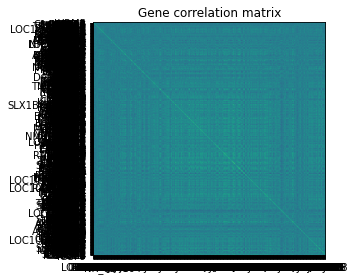

In [75]:
# plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(top_gene_train_corr)

ax.set_xticks(np.arange(top_gene_train_corr.shape[0]))
ax.set_yticks(np.arange(top_gene_train_corr.shape[0]))
ax.set_xticklabels(list(top_gene_train_corr))
ax.set_yticklabels(list(top_gene_train_corr))

ax.set_title("Most important gene correlation matrix")
fig.tight_layout()
plt.show()

In [ ]:
with open('xgb_clf_fit.sav', 'wb') as outfile:
    pickle.dump(xgb_clf, outfile)

## create ensemble pipeline

In [46]:
# load metadata
meta_df = pd.read_csv('/home/rimichael/Uni/biohack/biohack2020/data/meta/new_meta.tsv','\t')
x_meta_df = meta_df[["AGE", "TYPE", "MONTHS", "SURVIVAL"]]
y_meta_df = meta_df[["INTCLUST"]]
x_meta_train, x_meta_test, y_meta_train, y_meta_test = train_test_split(x_meta_df, y_meta_df, 
                                                                        test_size=0.25)
meta_df = meta_df.set_index("ID")
meta_df

,AGE,TYPE,MONTHS,SURVIVAL,INTCLUST
ID,,,,,
MB-0000,75.65,2,140.500000,1,4ER+
MB-0002,43.19,2,84.633333,1,4ER+
MB-0005,48.87,2,163.700000,2,3
MB-0010,78.77,2,7.800000,2,7
MB-0014,56.45,2,164.333333,1,3
...,...,...,...,...,...
MB-7295,43.10,1,196.866667,1,3
MB-7296,42.88,2,44.733333,2,5
MB-7297,62.90,2,175.966667,2,1


In [37]:
gene_data_df

,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,...,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A,INTCLUST
MB-0362,8.676978,6.075331,5.453928,4.994525,5.838270,6.397503,7.906217,5.259461,5.702379,6.930741,...,5.680321,7.688492,8.084979,5.161796,6.353215,4.836483,7.304643,5.251843,5.049591,2
MB-0346,9.653589,6.687887,5.454185,5.346010,5.600876,5.246319,8.267256,5.380069,5.521794,6.141689,...,5.461069,7.804165,8.349115,5.197392,6.132355,5.316819,7.933324,5.450611,5.316790,5
MB-0386,9.033589,5.910885,5.501577,5.247467,6.030718,10.111816,7.959291,5.262024,5.689533,6.529312,...,5.304030,7.934309,8.406332,8.087722,6.366335,5.466419,7.580336,5.235394,5.461617,9
MB-0574,8.814855,5.628740,5.471941,5.316523,5.849428,6.116868,9.206376,5.396576,5.439130,6.430102,...,5.632249,7.744562,8.310019,5.780062,6.424048,5.193150,6.903654,5.091927,5.227130,2
MB-0503,9.274265,5.908698,5.531743,5.244094,5.964661,7.828171,8.706646,5.167213,5.417484,6.684893,...,5.472185,7.701394,8.137014,5.498185,6.214301,5.274600,6.839417,5.315224,5.027476,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-5465,8.131637,9.101942,5.423027,4.939292,5.644587,5.611189,7.798269,5.219962,5.597732,6.583524,...,5.484696,7.643929,8.040024,5.456862,6.269748,5.337776,7.288315,5.359223,5.253696,10
MB-5453,9.606915,7.427494,5.534115,5.062191,5.927409,5.927031,8.520545,5.129501,5.550549,5.841476,...,5.538543,7.048923,7.560101,5.397010,7.088676,5.216496,7.248336,5.544276,5.436415,4ER-
MB-5471,9.049296,6.850000,5.339346,5.166765,6.117095,6.374305,8.499637,4.961279,5.497546,6.351428,...,5.386238,7.733413,7.941895,5.415928,6.110477,5.427567,7.596215,5.405179,5.094339,3
MB-5127,8.858622,6.550450,5.566071,5.140141,5.936371,5.963092,9.320207,5.408996,5.690297,7.280037,...,5.436583,7.311774,7.866579,5.242482,6.316304,4.977467,6.620605,5.631662,5.350708,1


In [49]:
# build total dataframe from gene metadata+ gene data
ensemble_data = meta_df.join(gene_data_df.drop(columns="INTCLUST"), how="left").dropna()
y_ensemble_data = ensemble_data["INTCLUST"]

ensemble_data = ensemble_data.drop(columns="INTCLUST")

X_ens_train , X_ens_test, y_ens_train, y_ens_test = train_test_split(ensemble_data, y_ensemble_data, 
                                                                        test_size=0.25)
X_ens_train

,AGE,TYPE,MONTHS,SURVIVAL,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,...,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
ID,,,,,,,,,,,,,,,,,,,,,
MB-3344,33.76,2,241.266667,1,9.264361,5.783187,5.574128,5.111294,5.912904,6.373077,...,5.660136,5.625169,6.593536,8.157173,5.192571,6.254913,5.313168,7.365611,5.447547,5.253593
MB-0652,85.12,2,96.633333,2,8.392811,5.456827,5.389955,5.300433,5.981484,5.378604,...,5.786935,5.362488,7.623105,8.260991,5.377228,5.953498,5.200438,7.528250,5.685383,5.925326
MB-5483,44.50,2,42.433333,2,8.325338,6.078283,5.557513,5.284789,5.709554,5.544304,...,5.779888,5.679261,7.957478,8.243762,5.423117,5.986088,5.257767,6.829128,5.227511,5.220382
MB-6008,80.33,1,69.100000,2,9.037100,6.172569,5.340657,5.670948,6.053164,6.311625,...,5.567413,5.606169,7.776195,8.470224,5.375875,6.817657,5.551713,7.400819,5.323828,5.367100
MB-5115,40.57,2,77.400000,1,8.698172,7.205689,5.472357,5.421933,5.907551,5.758675,...,5.591045,5.421220,7.191091,8.817122,5.406487,6.142126,5.377776,7.704529,5.487697,5.219945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-3123,50.26,2,167.433333,1,7.803532,6.499393,5.234381,5.470880,5.493186,5.658213,...,5.701318,5.560806,7.229468,8.474242,5.613481,6.086289,5.223455,7.320514,5.452185,5.117763
MB-5563,76.30,1,117.666667,2,9.591889,6.783438,5.299110,5.277379,5.853389,5.813207,...,5.779725,5.535441,7.497559,7.930073,5.190267,6.648916,5.310940,6.977609,5.409502,5.208131
MB-4717,43.51,2,42.900000,2,8.264833,6.770259,5.595090,5.241390,5.793496,5.374335,...,5.509942,5.437567,8.657966,8.421111,5.429058,6.399414,5.300222,7.453695,5.417752,5.121577


In [59]:
# fit metadata classifier
et = ExtraTreesClassifier(n_jobs=-1, n_estimators=1000, max_depth=7, min_samples_leaf=2)
et.fit(x_meta_train, y_train)
train_score = et.score(x_meta_train, y_meta_train)
test_score = et.score(x_meta_test,y_meta_test)

print("MetaData Train Score:")
print(train_score)
print("MetaData Test Score:")
print(test_score)

<ipython-input-59-3faa29e61a75>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  et.fit(x_meta_train, y_train)


MetaData Train Score:
0.12568306010928962
MetaData Test Score:
0.15690866510538642


In [33]:
class ColumnSelector(object):
    """
    A feature selector for scikit-learn's Pipeline class that returns
    specified columns from a numpy array.

    """

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, y=None):
        return X[:, self.cols]

    def fit(self, X, y=None):
        return self

In [79]:
gene_clf = RFE(XGBClassifier(n_estimators=150, booster="gbtree", 
                             learning_rate=0.1, max_depth=6,
                           nthread=6, verbose=2),
               GENES_SELECTION, step=0.25, verbose=1)
gene_clf.fit(X_gene_train, y_gene_train)

Fitting estimator with 24368 features.
Fitting estimator with 18276 features.
Fitting estimator with 12184 features.
Fitting estimator with 6092 features.


RFE(estimator=XGBClassifier(base_score=None, booster='gbtree',
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, gamma=None, gpu_id=None,
                            importance_type='gain',
                            interaction_constraints=None, learning_rate=0.1,
                            max_delta_step=None, max_depth=6,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=150,
                            n_jobs=None, nthread=6, num_parallel_tree=None,
                            objective='binary:logistic', random_state=None,
                            reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, subsample=None,
                            tree_method=None, validate_parameters=False,
                            verbose=2, verbosity=None),
    n_features_to_select=1000, step=0.25, verbose

In [80]:
gene_clf.score(X_gene_test, y_gene_test)

0.7817745803357314

In [95]:
gene_list = list(X_gene_train.iloc[:, gene_clf.support_])
gene_train_df = X_gene_train.iloc[:, gene_clf.support_]

gene_train_df

,RNF165,AI082173,SDS,CR749394,TAF15,BC033582,TM2D1,ITGA10,MARS2,MAGEC1,...,MCM10,TFF3,RRNAD1,R00495,GSPT2,EHBP1,FAM20B,VPS72,CSMD3,IGSF9
MB-4966,6.411249,5.314463,7.171869,5.449496,10.375599,5.219208,9.993588,6.278984,6.329347,5.441179,...,6.364241,13.197578,8.131058,5.738233,7.185659,8.269454,9.393831,7.983542,5.057194,7.583714
MB-0442,6.015336,5.244298,5.595616,5.372319,10.053390,5.429442,9.416736,6.397087,5.870693,5.423053,...,5.635470,10.199443,8.151290,5.400951,7.583288,8.764773,8.442770,7.944622,5.400700,6.767750
MB-4140,5.910744,5.101516,6.318411,5.283924,10.939640,5.313709,9.033669,6.421508,5.833153,5.473787,...,6.301619,13.717232,8.815094,5.610196,6.847700,7.732358,9.733669,8.329161,5.334215,6.618754
MB-0375,5.852575,5.320135,6.179701,5.333260,9.948910,5.280533,8.833708,6.254444,6.500594,5.306772,...,7.224271,8.268275,7.755983,5.389648,8.307310,7.764330,8.983534,8.627779,5.331394,7.459989
MB-4944,7.109797,5.287566,6.285579,5.313447,10.513836,5.356672,8.909695,7.155699,6.181256,5.170912,...,7.060508,13.781272,9.143433,5.356835,7.825783,8.296569,9.293867,8.604917,5.093681,7.847362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7046,6.228934,5.630381,6.512292,5.344893,9.874404,5.340353,9.434672,5.493015,6.608739,5.481609,...,6.971610,12.721868,8.228378,5.616822,6.842631,7.860154,10.065147,7.975453,5.308320,7.037958
MB-7220,7.071885,5.223185,6.279207,5.760391,10.005950,5.435605,9.581255,5.988956,6.030818,5.290035,...,6.397087,12.240355,8.496236,5.419853,6.624425,8.127791,9.575953,8.367442,5.149893,7.241848
MB-4881,7.121855,5.489841,6.451369,5.288827,9.583919,5.519763,8.665807,6.123142,6.726317,5.323956,...,8.569991,6.105563,8.259737,5.500646,8.093222,9.293263,8.720729,9.159409,5.267296,8.036148
MB-5486,6.234364,5.425631,6.414901,4.919336,9.867437,5.161432,8.858661,6.305379,6.498788,5.521326,...,6.712177,12.076902,8.132164,5.579290,6.984644,7.921991,8.873546,8.159615,5.250304,7.360788


In [81]:
with open("/home/rimichael/Uni/biohack/gene_model.sav", "wb") as outfile:
    pickle.dump(gene_clf, outfile)

In [ ]:
# compose pipeline - 1st:RFE on GENE clf + 2nd Meta clf => predict TCGA clusters (TRUTH Y)
# compose validation pipeline - CNA clf + meta clf => predict TCGA clusters
# compute loss between both

In [ ]:
# pick out highly correlated genes

In [92]:
# load TCGA data
tcga_df = pd.read_csv("/home/rimichael/Uni/biohack/tcga/data_expression_median.txt", 
                      sep="\t", index_col="Hugo_Symbol")
tcga_df = tcga_df.drop(columns="Entrez_Gene_Id").T.dropna()

In [112]:
tcga_df_v2 = pd.read_csv("/home/rimichael/Uni/biohack/tcga/data_RNA_Seq_v2_expression_median.txt", 
                         sep="\t", index_col="Hugo_Symbol")
tcga_df_v2 = tcga_df_v2.drop(columns="Entrez_Gene_Id").T.dropna()

In [93]:
tcga_df

Hugo_Symbol,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,ERCC5,GPR98,RXFP3,...,SLC2A11,GRIP2,GPLD1,RAB8A,RXFP2,PIK3IP1,SLC39A6,SNRPD2,AQP7,CTSC
TCGA-A1-A0SE-01,0.181417,0.89075,0.716000,0.13175,0.957833,-0.59025,-0.043667,-0.23850,-0.152250,0.4425,...,0.185833,-0.18750,-0.440000,0.5352,0.2570,2.81075,2.0736,-0.0675,-1.0095,-1.1553
TCGA-A1-A0SH-01,0.461500,2.25925,0.417125,0.32500,2.285500,-1.72675,0.420500,0.00725,-0.696000,0.2960,...,-0.001333,-0.26900,-0.996667,0.8484,0.6025,2.36950,0.5013,-0.1963,-1.0765,-0.7658
TCGA-A1-A0SJ-01,0.877000,0.43775,0.115000,0.75775,-0.089333,-1.78375,0.251000,0.03525,-0.640625,0.6885,...,0.455333,0.00025,-0.099500,0.1940,-0.1235,2.85725,3.0967,0.3321,1.5910,-0.7459
TCGA-A1-A0SK-01,1.412333,-0.63725,0.492875,0.94325,-1.233167,-2.75500,-1.331500,0.79100,0.014500,-0.0600,...,-0.669333,-0.11650,-0.634167,0.8949,0.0855,1.86000,-0.4288,0.0048,-1.0275,-0.6338
TCGA-A1-A0SM-01,1.666750,2.58000,-0.525000,0.64175,1.591500,-1.86975,0.059833,-0.17725,0.091875,0.1710,...,-0.480333,-0.32475,-1.282167,0.7529,0.6820,2.63200,0.7469,-0.7540,-1.0140,-0.9661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E2-A15P-01,0.672833,1.13775,0.063750,-0.08375,0.243667,-2.05750,-0.272667,-0.02725,-0.272250,-0.1995,...,-0.200833,-0.13375,-1.123333,0.7399,-0.3355,1.81700,2.3727,0.2436,-0.1835,-0.7119
TCGA-E2-A15R-01,1.187167,-0.31200,0.045250,1.33525,-0.136333,-1.98950,0.953500,-1.12050,-2.112125,0.3220,...,0.533333,-0.32850,0.282333,-0.1333,0.3040,1.71600,3.0555,-0.1486,-0.6885,-1.9186
TCGA-E2-A15S-01,0.351167,0.20625,-0.328750,0.14925,-1.567500,-2.24150,-0.218667,-0.40575,1.220500,0.2005,...,0.368833,-0.08700,1.583500,-1.1569,-0.0080,1.01800,4.1593,-0.3412,0.5870,-2.1024
TCGA-E2-A1AZ-01,0.284167,0.42825,0.781000,-0.20925,1.544167,-1.47750,-0.342667,-0.05475,-2.014875,0.4820,...,-0.221500,-0.29825,-1.914167,-0.2597,1.4645,1.34375,-2.0700,1.0056,-1.2645,1.3211


In [113]:
tcga_df_v2

Hugo_Symbol,UBE2Q2P2,HMGB1P1,LOC155060,RNU12-2P,SSX9,CXORF67,EFCAB8,SRP14P1,LOC391343,TRIM75P,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,TPTEP1,AKR1C6P
TCGA-A1-A0SB-01,14.3935,116.3870,279.7612,0.4505,0.0,0.9010,0.9010,1.8020,0.0000,0.4505,...,95.9568,519.4279,1415.9252,19.3716,1364.5681,6186.7327,1931.2986,1436.1978,552.3144,0.0000
TCGA-A1-A0SD-01,11.3241,60.2630,83.6986,0.3308,0.0,0.6616,0.3308,4.6315,0.3308,0.3308,...,96.2700,578.2814,1225.7051,33.0825,868.0837,3559.6725,1278.9678,1195.6000,86.0144,0.0000
TCGA-A1-A0SE-01,4.4426,153.1452,74.7018,0.0000,0.0,0.0000,0.9872,5.5944,0.3291,0.3291,...,95.4340,726.6146,1018.8400,57.5895,960.5923,3007.8157,926.3677,1075.4422,866.1456,0.0000
TCGA-A1-A0SF-01,10.7401,141.1933,314.4482,0.0000,0.0,0.0000,2.9988,9.4249,0.0000,0.0000,...,74.1138,533.3625,1053.4444,94.6772,881.2262,5343.4779,934.3482,508.0867,52.2652,0.8568
TCGA-A1-A0SH-01,3.0048,79.8003,95.7054,0.0000,0.0,0.0000,0.3612,3.9727,0.0000,0.0000,...,87.7601,581.0946,801.3977,19.8634,1353.2389,5464.9614,1312.7898,1001.1151,455.7746,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-MS-A51U-01,7.9343,150.6834,540.4278,1.5649,0.0,0.5216,0.0000,6.2598,0.0000,0.0000,...,79.2906,443.9228,1083.4637,40.6886,858.1116,4930.6208,2212.8326,665.6234,249.8696,0.0000
TCGA-OL-A66H-01,2.2519,115.3378,338.1985,2.0851,0.0,0.0000,2.0851,4.1701,0.0000,0.0000,...,45.4545,747.7064,903.6697,10.4254,634.2786,4163.4696,1251.8766,773.1443,5.8382,0.0000
TCGA-OL-A66I-01,1.2603,158.3599,210.7460,0.4173,0.0,2.0866,2.5039,2.5039,0.4173,0.0000,...,61.3459,334.2723,933.1247,206.1555,479.0819,6621.1789,649.3479,780.3860,47.1570,0.0000
TCGA-OL-A66J-01,5.0428,124.6327,323.1185,0.4507,0.0,0.0000,8.1118,5.8585,3.1546,0.0000,...,45.5160,797.6566,1038.3055,13.9703,683.1906,5216.7643,1408.7427,713.3844,567.3727,0.0000


In [134]:
# subselect most impactful genes
tcga_df[gene_list]

KeyError: "['DKFZp666P158', 'BF510065', 'TAB3', 'NCRNA00083', 'DB305498', 'CAPN8', 'LAMTOR1', 'FAM66C', 'BU687024', 'OR56A4', 'VWA5B2', 'DUPD1', 'BQ941622', 'FAM173A', 'FLJ43390', 'AW118757', 'FAM90A10', 'AA813384', 'DA529130', 'AA758030', 'CF887450', 'MBLAC2', 'ORC6', 'AI082173', 'BU689288', 'MCF2L-AS1', 'AI979035', 'GLYR1', 'LOC142937', 'LOC648570', 'AK130765', 'BX089476', 'WDYHV1', 'KRTAP27-1', 'BX089531', 'HIST2H2AA4', 'AA912497', 'CHTOP', 'SNX29', 'TMEM236', 'MRPL42P5', 'BQ022151', 'DB335284', 'BG192435', 'DB005376', 'BG681924', 'ANKLE2', 'AW295258', 'AA577794', 'AK097370', 'AA883814', 'BQ013083', 'BM931785', 'BE464555', 'CA437196', 'AW118655', 'CYTH1', 'BICC1', 'SELO', 'AA902912', 'AK123300', 'CN271561', 'AK023536', 'AI808705', 'AK097493', 'BX110742', 'BX105056', 'BC039338', 'CR738550', 'AA777331', 'ARSH', 'CR745388', 'AI681186', 'BM670198', 'C9orf144A', 'PPPDE1', 'CB044964', 'BF447104', 'BX090362', 'BG221407', 'BF510080', 'STRADA', 'CT45A6', 'CYP21A1P', 'BX099727', 'C16orf11', 'EL949448', 'AW162245', 'CR742828', 'GSDMC', 'DLGAP5', 'DKFZp434J2031', 'AK001020', 'N4BP2L2', 'MUC3B', 'PGAP3', 'NCRNA00111', 'OR52A5', 'C16orf88', 'SULT1A4', 'BM987718', 'ANKLE1', 'BX092796', 'GET4', 'FLJ32065', 'ITPRIPL1', 'NCCRP1', 'BI468268', 'AK024852', 'AW118645', 'UNQ9392', 'AW452144', 'AOX2', 'FAM21A', 'AI625535', 'ANGPTL6', 'AA454194', 'C6orf226', 'CR749394', 'AI187771', 'BU935198', 'AA724305', 'AW138182', 'LOC440292', 'AA309281', 'FLJ38576', 'AI655567', 'R00495', 'DB335528', 'AI703143', 'CK004173', 'AK094525', 'BM563971', 'RNF219', 'CDC45', 'DB361375', 'BF940367', 'FAM176B', 'AI025496', 'AA856966', 'AW827287', 'PRR15L', 'BU621634', 'FLJ44881', 'AI439310', 'TACO1', 'DEFB105A', 'LY49L', 'AA126469', 'METTL13', 'AK055323', 'MEAF6', 'AL040205', 'SNORD30', 'AI948757', 'DCAF6', 'ZNFPHEX133', 'RASA3', 'CA393731', 'POTEE', 'AK074961', 'ZUFSP', 'RRNAD1', 'AW514562', 'SNORD21', 'C8orf74', 'AW191734', 'RBM20', 'DQ896666', 'BX102316', 'BX102319', 'C19orf38', 'BX100262', 'TDRD12', 'LOC388387', 'OR52A4', 'AI138665', 'MURC', 'BMS1P4', 'BF675965', 'BM680881', 'BG694339', 'BQ185359', 'MGC45800', 'BM678668', 'DBX1', 'BX117292', 'BX099811', 'LINC00309', 'CK300032', 'DA101838', 'BM676336', 'BX090679', 'BU618600', 'BG210189', 'KRT39', 'AA689391', 'BF511322', 'DB075940', 'AA769834', 'BX099391', 'RALGAPB', 'DR977867', 'CYHR1', 'AF090908', 'LOC402778', 'AI609342', 'AK172857', 'BX100192', 'DB180818', 'BX096845', 'CPSF7', 'PRR11', 'TMEM8B', 'OR13C3', 'LOC124685', 'GJA9-MYCBP', 'AA909740', 'PAN2', 'AK129761', 'TYW1', 'MST4', 'CSDAP1', 'HEATR7B1', 'AKR1E2', 'CN430221', 'BM711518', 'AW299747', 'FOPNL', 'LOC149837', 'CR745891', 'AI684640', 'AK129671', 'AF095854', 'BM694243', 'HRCT1', 'WA1', 'BC033582', 'IQCF4', 'BC015376', 'FAM13A', 'CD359832', 'BE671155', 'PRR23C', 'BC140370', 'BM673887', 'DB036862', 'C15orf59', 'AK129612', 'BQ771683', 'TSEN15', 'KDM1B', 'EFCAB11', 'CR624623', 'CF887426', 'AA809128', 'CHADL', 'AK057408', 'C16orf93', 'AI525756', 'AW513776', 'HBBP1', 'AW665857', 'AI698810', 'AI932382', 'ALG1L', 'DCAF4', 'AK055561', 'BX100240', 'AK172772', 'AI193410', 'BX109404', 'LOC284100', 'VANGL2', 'OPN1MW2', 'NAT15', 'BC014362', 'H2BFM', 'LY6G6F', 'FGF16', 'CN294310', 'ZNF818P', 'BQ773724', 'SUN2', 'ACAP3', 'AA705831', 'DB311803', 'BE326664', 'C10orf71', 'AA906297', 'DA296814', 'CX780912', 'KDM4B', 'PPDPF', 'BF507608', 'BX118153', 'AF385432', 'BM997027'] not in index"

In [99]:
# list of genes not contained in TCGA
solo_genes = ['DKFZp666P158', 'BF510065', 'TAB3', 'NCRNA00083', 'DB305498', 'CAPN8', 'LAMTOR1', 'FAM66C', 'BU687024', 'OR56A4', 'VWA5B2', 'DUPD1', 'BQ941622', 'FAM173A', 'FLJ43390', 'AW118757', 'FAM90A10', 'AA813384', 'DA529130', 'AA758030', 'CF887450', 'MBLAC2', 'ORC6', 'AI082173', 'BU689288', 'MCF2L-AS1', 'AI979035', 'GLYR1', 'LOC142937', 'LOC648570', 'AK130765', 'BX089476', 'WDYHV1', 'KRTAP27-1', 'BX089531', 'HIST2H2AA4', 'AA912497', 'CHTOP', 'SNX29', 'TMEM236', 'MRPL42P5', 'BQ022151', 'DB335284', 'BG192435', 'DB005376', 'BG681924', 'ANKLE2', 'AW295258', 'AA577794', 'AK097370', 'AA883814', 'BQ013083', 'BM931785', 'BE464555', 'CA437196', 'AW118655', 'CYTH1', 'BICC1', 'SELO', 'AA902912', 'AK123300', 'CN271561', 'AK023536', 'AI808705', 'AK097493', 'BX110742', 'BX105056', 'BC039338', 'CR738550', 'AA777331', 'ARSH', 'CR745388', 'AI681186', 'BM670198', 'C9orf144A', 'PPPDE1', 'CB044964', 'BF447104', 'BX090362', 'BG221407', 'BF510080', 'STRADA', 'CT45A6', 'CYP21A1P', 'BX099727', 'C16orf11', 'EL949448', 'AW162245', 'CR742828', 'GSDMC', 'DLGAP5', 'DKFZp434J2031', 'AK001020', 'N4BP2L2', 'MUC3B', 'PGAP3', 'NCRNA00111', 'OR52A5', 'C16orf88', 'SULT1A4', 'BM987718', 'ANKLE1', 'BX092796', 'GET4', 'FLJ32065', 'ITPRIPL1', 'NCCRP1', 'BI468268', 'AK024852', 'AW118645', 'UNQ9392', 'AW452144', 'AOX2', 'FAM21A', 'AI625535', 'ANGPTL6', 'AA454194', 'C6orf226', 'CR749394', 'AI187771', 'BU935198', 'AA724305', 'AW138182', 'LOC440292', 'AA309281', 'FLJ38576', 'AI655567', 'R00495', 'DB335528', 'AI703143', 'CK004173', 'AK094525', 'BM563971', 'RNF219', 'CDC45', 'DB361375', 'BF940367', 'FAM176B', 'AI025496', 'AA856966', 'AW827287', 'PRR15L', 'BU621634', 'FLJ44881', 'AI439310', 'TACO1', 'DEFB105A', 'LY49L', 'AA126469', 'METTL13', 'AK055323', 'MEAF6', 'AL040205', 'SNORD30', 'AI948757', 'DCAF6', 'ZNFPHEX133', 'RASA3', 'CA393731', 'POTEE', 'AK074961', 'ZUFSP', 'RRNAD1', 'AW514562', 'SNORD21', 'C8orf74', 'AW191734', 'RBM20', 'DQ896666', 'BX102316', 'BX102319', 'C19orf38', 'BX100262', 'TDRD12', 'LOC388387', 'OR52A4', 'AI138665', 'MURC', 'BMS1P4', 'BF675965', 'BM680881', 'BG694339', 'BQ185359', 'MGC45800', 'BM678668', 'DBX1', 'BX117292', 'BX099811', 'LINC00309', 'CK300032', 'DA101838', 'BM676336', 'BX090679', 'BU618600', 'BG210189', 'KRT39', 'AA689391', 'BF511322', 'DB075940', 'AA769834', 'BX099391', 'RALGAPB', 'DR977867', 'CYHR1', 'AF090908', 'LOC402778', 'AI609342', 'AK172857', 'BX100192', 'DB180818', 'BX096845', 'CPSF7', 'PRR11', 'TMEM8B', 'OR13C3', 'LOC124685', 'GJA9-MYCBP', 'AA909740', 'PAN2', 'AK129761', 'TYW1', 'MST4', 'CSDAP1', 'HEATR7B1', 'AKR1E2', 'CN430221', 'BM711518', 'AW299747', 'FOPNL', 'LOC149837', 'CR745891', 'AI684640', 'AK129671', 'AF095854', 'BM694243', 'HRCT1', 'WA1', 'BC033582', 'IQCF4', 'BC015376', 'FAM13A', 'CD359832', 'BE671155', 'PRR23C', 'BC140370', 'BM673887', 'DB036862', 'C15orf59', 'AK129612', 'BQ771683', 'TSEN15', 'KDM1B', 'EFCAB11', 'CR624623', 'CF887426', 'AA809128', 'CHADL', 'AK057408', 'C16orf93', 'AI525756', 'AW513776', 'HBBP1', 'AW665857', 'AI698810', 'AI932382', 'ALG1L', 'DCAF4', 'AK055561', 'BX100240', 'AK172772', 'AI193410', 'BX109404', 'LOC284100', 'VANGL2', 'OPN1MW2', 'NAT15', 'BC014362', 'H2BFM', 'LY6G6F', 'FGF16', 'CN294310', 'ZNF818P', 'BQ773724', 'SUN2', 'ACAP3', 'AA705831', 'DB311803', 'BE326664', 'C10orf71', 'AA906297', 'DA296814', 'CX780912', 'KDM4B', 'PPDPF', 'BF507608', 'BX118153', 'AF385432', 'BM997027']
print(len(solo_genes))
solo_genes

298


['DKFZp666P158',
 'BF510065',
 'TAB3',
 'NCRNA00083',
 'DB305498',
 'CAPN8',
 'LAMTOR1',
 'FAM66C',
 'BU687024',
 'OR56A4',
 'VWA5B2',
 'DUPD1',
 'BQ941622',
 'FAM173A',
 'FLJ43390',
 'AW118757',
 'FAM90A10',
 'AA813384',
 'DA529130',
 'AA758030',
 'CF887450',
 'MBLAC2',
 'ORC6',
 'AI082173',
 'BU689288',
 'MCF2L-AS1',
 'AI979035',
 'GLYR1',
 'LOC142937',
 'LOC648570',
 'AK130765',
 'BX089476',
 'WDYHV1',
 'KRTAP27-1',
 'BX089531',
 'HIST2H2AA4',
 'AA912497',
 'CHTOP',
 'SNX29',
 'TMEM236',
 'MRPL42P5',
 'BQ022151',
 'DB335284',
 'BG192435',
 'DB005376',
 'BG681924',
 'ANKLE2',
 'AW295258',
 'AA577794',
 'AK097370',
 'AA883814',
 'BQ013083',
 'BM931785',
 'BE464555',
 'CA437196',
 'AW118655',
 'CYTH1',
 'BICC1',
 'SELO',
 'AA902912',
 'AK123300',
 'CN271561',
 'AK023536',
 'AI808705',
 'AK097493',
 'BX110742',
 'BX105056',
 'BC039338',
 'CR738550',
 'AA777331',
 'ARSH',
 'CR745388',
 'AI681186',
 'BM670198',
 'C9orf144A',
 'PPPDE1',
 'CB044964',
 'BF447104',
 'BX090362',
 'BG221407',
 

In [101]:
X_gene_train_adj = X_gene_train[gene_list].drop(columns=solo_genes)
X_gene_train_adj

,RNF165,SDS,TAF15,TM2D1,ITGA10,MARS2,MAGEC1,C17orf37,F11,FUBP1,...,RNF40,RND1,MCM10,TFF3,GSPT2,EHBP1,FAM20B,VPS72,CSMD3,IGSF9
MB-4966,6.411249,7.171869,10.375599,9.993588,6.278984,6.329347,5.441179,6.141009,5.718883,6.609740,...,7.891743,5.907622,6.364241,13.197578,7.185659,8.269454,9.393831,7.983542,5.057194,7.583714
MB-0442,6.015336,5.595616,10.053390,9.416736,6.397087,5.870693,5.423053,5.852212,5.447918,6.241986,...,7.641965,5.712823,5.635470,10.199443,7.583288,8.764773,8.442770,7.944622,5.400700,6.767750
MB-4140,5.910744,6.318411,10.939640,9.033669,6.421508,5.833153,5.473787,6.502238,5.550992,6.165147,...,8.703013,6.024650,6.301619,13.717232,6.847700,7.732358,9.733669,8.329161,5.334215,6.618754
MB-0375,5.852575,6.179701,9.948910,8.833708,6.254444,6.500594,5.306772,6.010486,5.467545,6.565301,...,7.602992,5.724623,7.224271,8.268275,8.307310,7.764330,8.983534,8.627779,5.331394,7.459989
MB-4944,7.109797,6.285579,10.513836,8.909695,7.155699,6.181256,5.170912,6.253116,5.608952,6.429846,...,8.620868,5.760776,7.060508,13.781272,7.825783,8.296569,9.293867,8.604917,5.093681,7.847362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7046,6.228934,6.512292,9.874404,9.434672,5.493015,6.608739,5.481609,7.775299,5.574108,6.149923,...,8.256024,6.796947,6.971610,12.721868,6.842631,7.860154,10.065147,7.975453,5.308320,7.037958
MB-7220,7.071885,6.279207,10.005950,9.581255,5.988956,6.030818,5.290035,6.229945,5.631000,6.046913,...,7.828706,5.573103,6.397087,12.240355,6.624425,8.127791,9.575953,8.367442,5.149893,7.241848
MB-4881,7.121855,6.451369,9.583919,8.665807,6.123142,6.726317,5.323956,6.041985,5.486708,6.288388,...,8.405291,5.332968,8.569991,6.105563,8.093222,9.293263,8.720729,9.159409,5.267296,8.036148
MB-5486,6.234364,6.414901,9.867437,8.858661,6.305379,6.498788,5.521326,5.954324,5.593599,6.296075,...,7.610253,6.304982,6.712177,12.076902,6.984644,7.921991,8.873546,8.159615,5.250304,7.360788


In [103]:
minimal_xgb_clf = XGBClassifier(n_estimators=150, booster="gbtree", 
                             learning_rate=0.1, max_depth=6,
                           nthread=6, verbose=2)
minimal_xgb_clf.fit(X_gene_train_adj, y_gene_train)

minimal_xgb_clf.score(X_gene_test[list(X_gene_train_adj)], y_gene_test)

0.815347721822542

In [104]:
y_hat = minimal_xgb_clf.predict(tcga_df[list(X_gene_train_adj)])
y_hat

array(['4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
       '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+', '4ER+',
      

In [130]:
# deselect genes that are not in the fit - adjust training data

solo_genes_v2 = ['C12orf60', 'FAM36A', 'KIAA1984', 'KIAA0146', 'BRP44', 'KIAA0649', 'C17orf37', 'C10orf47', 'C17orf66', 'C3orf26', 'FAIM3', 'C3orf25', 'C11orf10', 'C10orf11', 'LASS2', 'C11orf54', 'C10orf92', 'RABL5', 'MCM3APAS', 'GPR172A', 'C20orf103', 'C8orf38', 'C7orf13', 'C20orf3', 'KIAA1751', 'SC5DL', 'ZNF259', 'psiTPTE22', 'C7orf28B', 'GPR97', 'C3orf57', 'C17orf28', 'C9orf167', 'C4orf40', 'C17orf58', 'C9orf21', 'SYT14L', 'C1orf131', 'MTERFD1', 'C11orf64', 'C16orf7', 'C6orf97', 'C1orf183', 'ZNF658B', 'C1orf112', 'C1orf177', 'C11orf67', 'C16orf79', 'C1orf135']

solo_genes_tot = solo_genes + solo_genes_v2

In [133]:
X_gene_train_adj = X_gene_train.drop(columns=solo_genes_tot)
X_gene_train_adj

TypeError: unhashable type: 'list'

In [122]:
min_xgb_clf = XGBClassifier(n_estimators=150, booster="gbtree", 
                             learning_rate=0.1, max_depth=6,
                           nthread=6, verbose=2)
min_xgb_clf.fit(X_gene_train_adj, y_gene_train)

min_xgb_clf.score(X_gene_test[list(X_gene_train_adj)], y_gene_test)

0.815347721822542

In [126]:
y_hat_v2 = min_xgb_clf.predict(tcga_df_v2[list(X_gene_train_adj)])
y_hat_v2

KeyError: "['C12orf60', 'FAM36A', 'KIAA1984', 'KIAA0146', 'BRP44', 'KIAA0649', 'C17orf37', 'C10orf47', 'C17orf66', 'C3orf26', 'FAIM3', 'C3orf25', 'C11orf10', 'C10orf11', 'LASS2', 'C11orf54', 'C10orf92', 'RABL5', 'MCM3APAS', 'GPR172A', 'C20orf103', 'C8orf38', 'C7orf13', 'C20orf3', 'KIAA1751', 'SC5DL', 'ZNF259', 'psiTPTE22', 'C7orf28B', 'GPR97', 'C3orf57', 'C17orf28', 'C9orf167', 'C4orf40', 'C17orf58', 'C9orf21', 'SYT14L', 'C1orf131', 'MTERFD1', 'C11orf64', 'C16orf7', 'C6orf97', 'C1orf183', 'ZNF658B', 'C1orf112', 'C1orf177', 'C11orf67', 'C16orf79', 'C1orf135'] not in index"